# **Домашнее задание #3. Шагающие человечки**

## **Часть 0. Вспоминаем код архитектуры и проверяем работоспособность детектора**

In [ ]:
import os
import torch
import torchvision
import torch.nn.functional as F

from torch import nn
from math import sqrt
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont

import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device

device(type='cuda')

In [ ]:
## VGG Backbone
class VGGBase(nn.Module):
    def __init__(self):
        super(VGGBase, self).__init__()

        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)

        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)  
        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)

        self.load_pretrained_layers()

    def forward(self, image):
        out = F.relu(self.conv1_1(image))
        out = F.relu(self.conv1_2(out))
        out = self.pool1(out)

        out = F.relu(self.conv2_1(out))
        out = F.relu(self.conv2_2(out))
        out = self.pool2(out)

        out = F.relu(self.conv3_1(out))
        out = F.relu(self.conv3_2(out))
        out = F.relu(self.conv3_3(out)) 
        out = self.pool3(out)

        out = F.relu(self.conv4_1(out))
        out = F.relu(self.conv4_2(out))
        out = F.relu(self.conv4_3(out))
        conv4_3_feats = out

        out = self.pool4(out)
        out = F.relu(self.conv5_1(out))
        out = F.relu(self.conv5_2(out))
        out = F.relu(self.conv5_3(out))
        out = self.pool5(out)           
        out = F.relu(self.conv6(out))   
        conv7_feats = F.relu(self.conv7(out))

        return conv4_3_feats, conv7_feats

    def load_pretrained_layers(self):
        state_dict = self.state_dict()
        param_names = list(state_dict.keys())

        pretrained_state_dict = torchvision.models.vgg16(pretrained=True).state_dict()
        pretrained_param_names = list(pretrained_state_dict.keys())

        for i, param in enumerate(param_names[:-4]): 
            state_dict[param] = pretrained_state_dict[pretrained_param_names[i]]

        conv_fc6_weight = pretrained_state_dict['classifier.0.weight'].view(4096, 512, 7, 7)
        conv_fc6_bias = pretrained_state_dict['classifier.0.bias']
        
        state_dict['conv6.weight'] = decimate(conv_fc6_weight, m=[4, None, 3, 3]) 
        state_dict['conv6.bias'] = decimate(conv_fc6_bias, m=[4])
        
        conv_fc7_weight = pretrained_state_dict['classifier.3.weight'].view(4096, 4096, 1, 1)
        conv_fc7_bias = pretrained_state_dict['classifier.3.bias'] 

        state_dict['conv7.weight'] = decimate(conv_fc7_weight, m=[4, 4, None, None]) 
        state_dict['conv7.bias'] = decimate(conv_fc7_bias, m=[4])

        self.load_state_dict(state_dict)

        print("\n Loaded backbone.\n")

def decimate(tensor, m):
    assert tensor.dim() == len(m)
    for d in range(tensor.dim()):
        if m[d] is not None:
            tensor = tensor.index_select(dim=d, index=torch.arange(start=0, end=tensor.size(d), step=m[d]).long())
    return tensor

In [ ]:
class AuxiliaryConvolutions(nn.Module):
    def __init__(self):
        super(AuxiliaryConvolutions, self).__init__()
        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, padding=0) 
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)

        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, padding=0)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)

        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)

        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)

    def forward(self, conv7_feats):
        out = F.relu(self.conv8_1(conv7_feats)) 
        out = F.relu(self.conv8_2(out))  
        conv8_2_feats = out 

        out = F.relu(self.conv9_1(out))
        out = F.relu(self.conv9_2(out)) 
        conv9_2_feats = out 

        out = F.relu(self.conv10_1(out)) 
        out = F.relu(self.conv10_2(out))
        conv10_2_feats = out  

        out = F.relu(self.conv11_1(out))
        out = F.relu(self.conv11_2(out))
        conv11_2_feats = out

        return conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats


class PredictionConvolutions(nn.Module):
    def __init__(self, n_classes):
        super(PredictionConvolutions, self).__init__()
        self.n_classes = n_classes

        n_boxes = {'conv4_3': 4, 'conv7': 6, 'conv8_2': 6,
                   'conv9_2': 6, 'conv10_2': 4, 'conv11_2': 4}

        self.loc_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * 4, kernel_size=3, padding=1)
        self.loc_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * 4, kernel_size=3, padding=1)
        self.loc_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * 4, kernel_size=3, padding=1)

        self.cl_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * n_classes, kernel_size=3, padding=1)

    def forward(self, conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats):
        batch_size = conv4_3_feats.size(0)

        l_conv4_3 = self.loc_conv4_3(conv4_3_feats) 
        l_conv4_3 = l_conv4_3.permute(0, 2, 3, 1).contiguous()
        l_conv4_3 = l_conv4_3.view(batch_size, -1, 4)

        l_conv7 = self.loc_conv7(conv7_feats)
        l_conv7 = l_conv7.permute(0, 2, 3, 1).contiguous()
        l_conv7 = l_conv7.view(batch_size, -1, 4)

        l_conv8_2 = self.loc_conv8_2(conv8_2_feats)
        l_conv8_2 = l_conv8_2.permute(0, 2, 3, 1).contiguous()
        l_conv8_2 = l_conv8_2.view(batch_size, -1, 4)

        l_conv9_2 = self.loc_conv9_2(conv9_2_feats)
        l_conv9_2 = l_conv9_2.permute(0, 2, 3, 1).contiguous()
        l_conv9_2 = l_conv9_2.view(batch_size, -1, 4)

        l_conv10_2 = self.loc_conv10_2(conv10_2_feats) 
        l_conv10_2 = l_conv10_2.permute(0, 2, 3, 1).contiguous()
        l_conv10_2 = l_conv10_2.view(batch_size, -1, 4)

        l_conv11_2 = self.loc_conv11_2(conv11_2_feats) 
        l_conv11_2 = l_conv11_2.permute(0, 2, 3, 1).contiguous()
        l_conv11_2 = l_conv11_2.view(batch_size, -1, 4)

        c_conv4_3 = self.cl_conv4_3(conv4_3_feats)
        c_conv4_3 = c_conv4_3.permute(0, 2, 3, 1).contiguous()
        c_conv4_3 = c_conv4_3.view(batch_size, -1, self.n_classes)

        c_conv7 = self.cl_conv7(conv7_feats)
        c_conv7 = c_conv7.permute(0, 2, 3, 1).contiguous()
        c_conv7 = c_conv7.view(batch_size, -1,self.n_classes)

        c_conv8_2 = self.cl_conv8_2(conv8_2_feats)
        c_conv8_2 = c_conv8_2.permute(0, 2, 3, 1).contiguous()
        c_conv8_2 = c_conv8_2.view(batch_size, -1, self.n_classes)

        c_conv9_2 = self.cl_conv9_2(conv9_2_feats)
        c_conv9_2 = c_conv9_2.permute(0, 2, 3, 1).contiguous()
        c_conv9_2 = c_conv9_2.view(batch_size, -1, self.n_classes)

        c_conv10_2 = self.cl_conv10_2(conv10_2_feats)
        c_conv10_2 = c_conv10_2.permute(0, 2, 3, 1).contiguous()
        c_conv10_2 = c_conv10_2.view(batch_size, -1, self.n_classes)

        c_conv11_2 = self.cl_conv11_2(conv11_2_feats)
        c_conv11_2 = c_conv11_2.permute(0, 2, 3, 1).contiguous()
        c_conv11_2 = c_conv11_2.view(batch_size, -1, self.n_classes)

        locs = torch.cat([l_conv4_3, l_conv7, l_conv8_2, l_conv9_2, l_conv10_2, l_conv11_2], dim=1)
        classes_scores = torch.cat([c_conv4_3, c_conv7, c_conv8_2, c_conv9_2, c_conv10_2, c_conv11_2], dim=1)

        return locs, classes_scores

In [ ]:
class SSD300_(nn.Module):
    def __init__(self, n_classes):
        super(SSD300_, self).__init__()
        self.n_classes = n_classes

        self.base = VGGBase()
        self.aux_convs = AuxiliaryConvolutions()
        self.pred_convs = PredictionConvolutions(n_classes)

        self.priors_cxcy = self.create_prior_boxes()
        self.rescale_factors = nn.Parameter(torch.FloatTensor(1, 512, 1, 1)) 
        nn.init.constant_(self.rescale_factors, 20)

    def create_prior_boxes(self):
        fmap_dims = {'conv4_3': 38, 'conv7': 19, 'conv8_2': 10,
                     'conv9_2': 5, 'conv10_2': 3, 'conv11_2': 1}

        obj_scales = {'conv4_3': 0.1, 'conv7': 0.2, 'conv8_2': 0.375,
                      'conv9_2': 0.55, 'conv10_2': 0.725, 'conv11_2': 0.9}
        
        aspect_ratios = {'conv4_3': [1., 2., 0.5], 'conv7': [1., 2., 3., 0.5, 0.333],
                         'conv8_2': [1., 2., 3., 0.5, 0.333], 'conv9_2': [1., 2., 3., 0.5, 0.333],
                         'conv10_2': [1., 2., 0.5], 'conv11_2': [1., 2., 0.5]}

        prior_boxes = []
        fmaps = list(fmap_dims.keys())

        for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]): 
                for j in range(fmap_dims[fmap]): 
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]

                    for ratio in aspect_ratios[fmap]:
                        prior_boxes.append([cx, cy, obj_scales[fmap] * sqrt(ratio), obj_scales[fmap] / sqrt(ratio)])

                        if ratio == 1.:
                            try:
                                additional_scale = sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])

                            except IndexError:
                                additional_scale = 1.
                            prior_boxes.append([cx, cy, additional_scale, additional_scale])

        prior_boxes = torch.FloatTensor(prior_boxes).to(device)
        prior_boxes.clamp_(0, 1)
        return prior_boxes

    def forward(self, image):
      conv4_3_feats, conv7_feats = self.base(image)  

      norm = conv4_3_feats.pow(2).sum(dim=1, keepdim=True).sqrt()
      conv4_3_feats = conv4_3_feats / norm 
      conv4_3_feats = conv4_3_feats * self.rescale_factors  

      conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats = self.aux_convs(conv7_feats)  

      locs, classes_scores = self.pred_convs(conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, 
                                              conv10_2_feats, conv11_2_feats)

      return locs, classes_scores

In [ ]:
#Вспомогательные функции
#(c_x, c_y, w, h) -> (x_min, y_min, x_max, y_max)
def cxcy_to_xy(cxcy):
    return torch.cat([cxcy[:, :2] - (cxcy[:, 2:] / 2),  # x_min, y_min
                      cxcy[:, :2] + (cxcy[:, 2:] / 2)], 1)  # x_max, y_max

#(c_x, c_y, w, h) -> (g_c_x, g_c_y,  g_w, g_h)
def cxcy_to_gcxgcy(cxcy, priors_cxcy):
    return torch.cat([(cxcy[:, :2] - priors_cxcy[:, :2]) / (priors_cxcy[:, 2:] / 10), 
                      torch.log(cxcy[:, 2:] / priors_cxcy[:, 2:]) * 5], 1) 

#(g_c_x, g_c_y,  g_w, g_h) -> (c_x, c_y, w, h)
def gcxgcy_to_cxcy(gcxgcy, priors_cxcy):
    return torch.cat([gcxgcy[:, :2] * priors_cxcy[:, 2:] / 10 + priors_cxcy[:, :2], 
                      torch.exp(gcxgcy[:, 2:] / 5) * priors_cxcy[:, 2:]], 1)
    

def xy_to_cxcy(xy):
    return torch.cat([(xy[:, 2:] + xy[:, :2]) / 2,  # c_x, c_y
                      xy[:, 2:] - xy[:, :2]], 1)  # w, h


def find_intersection(set_1, set_2):
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0)) 
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0) 
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1] 


def find_jaccard_overlap(set_1, set_2):
    intersection = find_intersection(set_1, set_2) 
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])

    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection 
    return intersection / union

In [ ]:
class SSD300(SSD300_):
  def detect_objects(self, predicted_locs, predicted_scores, min_score, max_overlap, top_k):
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)

        predicted_scores = F.softmax(predicted_scores, dim=2)

        all_images_boxes = list()
        all_images_labels = list()
        all_images_scores = list()

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        for i in range(batch_size):
            decoded_locs = cxcy_to_xy(gcxgcy_to_cxcy(predicted_locs[i], self.priors_cxcy))

            image_boxes = list()
            image_labels = list()
            image_scores = list()

            max_scores, best_label = predicted_scores[i].max(dim=1) 

            for c in range(1, self.n_classes):
                class_scores = predicted_scores[i][:, c]
                score_above_min_score = class_scores > min_score 
                n_above_min_score = score_above_min_score.sum().item()
                if n_above_min_score == 0:
                    continue
 
                class_scores = class_scores[score_above_min_score]
                class_decoded_locs = decoded_locs[score_above_min_score] 

                class_scores, sort_ind = class_scores.sort(dim=0, descending=True)  
                class_decoded_locs = class_decoded_locs[sort_ind] 

                overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)  

                # Non-Maximum Suppression (NMS)
                suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(device)

                for box in range(class_decoded_locs.size(0)):
                    if suppress[box] == 1:
                        continue

                    suppress = suppress | (overlap[box] > max_overlap)
                    suppress[box] = 0

                image_boxes.append(class_decoded_locs[1 - suppress])
                image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).to(device))
                image_scores.append(class_scores[1 - suppress])

            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
                image_labels.append(torch.LongTensor([0]).to(device))
                image_scores.append(torch.FloatTensor([0.]).to(device))

            image_boxes = torch.cat(image_boxes, dim=0) 
            image_labels = torch.cat(image_labels, dim=0)
            image_scores = torch.cat(image_scores, dim=0) 
            n_objects = image_scores.size(0)

            if n_objects > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k] 
                image_boxes = image_boxes[sort_ind][:top_k] 
                image_labels = image_labels[sort_ind][:top_k] 

            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)

        return all_images_boxes, all_images_labels, all_images_scores

In [ ]:
class MultiBoxLoss(nn.Module):
    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1.):
        super(MultiBoxLoss, self).__init__()

        self.priors_cxcy = priors_cxcy
        self.priors_xy = cxcy_to_xy(priors_cxcy)
        self.threshold = threshold 
        self.neg_pos_ratio = neg_pos_ratio 
        self.alpha = alpha

        self.smooth_l1 = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduce=False)

    def forward(self, predicted_locs, predicted_scores, boxes, labels):
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        n_classes = predicted_scores.size(2)

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).to(device)
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).to(device)

        #каждую картинку отдельно обрабатываем
        for i in range(batch_size):
            n_objects = boxes[i].size(0)
            overlap = find_jaccard_overlap(boxes[i].to(device), self.priors_xy) 
            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)
            _, prior_for_each_object = overlap.max(dim=1)
            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).to(device)
            overlap_for_each_prior[prior_for_each_object] = 1.
            label_for_each_prior = labels[i][object_for_each_prior]
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0
            true_classes[i] = label_for_each_prior
            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]).to(device), self.priors_cxcy)  # (8732, 4)

        positive_priors = true_classes != 0

        # LOCALIZATION LOSS
        loc_loss = self.smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])  #scalar

        # CONFIDENCE LOSS
        n_positives = positive_priors.sum(dim=1)
        n_hard_negatives = self.neg_pos_ratio * n_positives

        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))
        conf_loss_all = conf_loss_all.view(batch_size, n_priors) 
        conf_loss_pos = conf_loss_all[positive_priors]
        conf_loss_neg = conf_loss_all.clone()
        conf_loss_neg[positive_priors] = 0.  
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)

        hardness_ranks = torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(conf_loss_neg).to(device)
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]

        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()

        return conf_loss + self.alpha * loc_loss

In [ ]:
#будем использовать модель предобученную на Pascal VOC, вот его классы
voc_labels = ('background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
              'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')

label_map = {k: v for v, k in enumerate(voc_labels)}
rev_label_map = {v: k for k, v in label_map.items()} 

# Color map for bounding boxes of detected objects from https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
distinct_colors = ['#e6194b', '#3cb44b', '#ffe119', '#0082c8', '#f58231', '#911eb4', '#46f0f0', '#f032e6',
                   '#d2f53c', '#fabebe', '#008080', '#000080', '#aa6e28', '#fffac8', '#800000', '#aaffc3', '#808000',
                   '#ffd8b1', '#e6beff', '#808080', '#FFFFFF']
label_color_map = {k: distinct_colors[i] for i, k in enumerate(label_map.keys())}

### **Задание 0** (1 балл) 

[Скачайте](https://drive.google.com/file/d/1ySBa0zbcd-59zan-8c0gwbmywd8dEq5h/view?usp=sharing) обученные на `Pascal VOC` веса для этой модели. Положите их себе на drive.

Подгрузите веса и протестите ssd на [одной из картинок](https://www.google.com/url?sa=i&url=https%3A%2F%2Fvk.com%2F%40shizpub-ochen-dovolnyi-pesel&psig=AOvVaw0ef1A0Qgda7GjhW3d9Fs-w&ust=1635250162815000&source=images&cd=vfe&ved=0CAsQjRxqFwoTCMiZmt_D5fMCFQAAAAAdAAAAABAE) (мы же хотим убедиться что с весами всё ок).

In [ ]:
ssd = SSD300(len(voc_labels))


 Loaded backbone.



In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
data_path = 'gdrive/MyDrive'
checkpoint = torch.load(data_path + '/checkpoint_ssd300_pascal_voc.pth', map_location=device)
ssd.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
ssd = ssd.to(device)
ssd.eval()

SSD300(
  (base): VGGBase(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), 

In [ ]:
resize = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [ ]:
path_to_img = data_path + '/1.jpg'
original_image = Image.open(path_to_img)

transform = transforms.Compose([resize, to_tensor, normalize])
img = transform(original_image).to(device)
img = img[None, :]

In [ ]:
locs, scores = ssd(img)
det_boxes, det_labels, det_scores = ssd.detect_objects(locs.detach(), scores.detach(), min_score=0.7, max_overlap=0.5, top_k=1)

In [ ]:
original_dims = torch.FloatTensor([original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0).to(device)
det_boxes = det_boxes[0] * original_dims
det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]

In [ ]:
def draw_boxes(original_image, det_boxes, det_labels, label_color_map):
  annotated_image = original_image.copy()
  draw = ImageDraw.Draw(annotated_image)
  font = ImageFont.load_default()

  for i in range(det_boxes.size(0)):
    # Boxes
    box_location = det_boxes[i].tolist()
    draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
    draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[det_labels[i]]) 

    # Text
    text_size = font.getsize(det_labels[i].upper())
    text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
    textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4., box_location[1]]
    draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
    draw.text(xy=text_location, text=det_labels[i].upper(), fill='white',font=font)
  return annotated_image

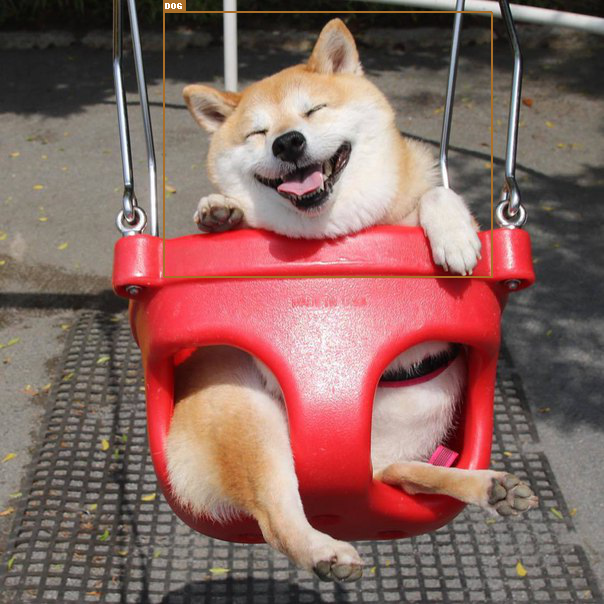

In [ ]:
draw_boxes(original_image, det_boxes, det_labels, label_color_map)

Попробуйте поиграться с гиперпараметрами чтобы получилось лучшее качаство на этой картинке. 

В целом результат не слишком великолепен - обучен детектор на небольшой базе `Pascal VOC`, мы используем не самую сильную его версию - `ssd300`, но даже с такими вводными у нас получится сделать интересное, let's get it started. 

## **Часть 1. Копаемся в данных**

На этот раз  у нас будет небольшой датасет из гуляющих людей (вы удивитесь насколько небольшой). Данные можно скачать [здесь](https://drive.google.com/file/d/1_8mnenRzV6ylr7L29LuhQHKd82GNzU9y/view?usp=sharing).

Для того, чтобы учить сеть, нужен будет `Dataloader`, а значит и собственный `Dataset`. Чтобы собрать `Dataset`, надо понять как выглядят данные и аннотация, а также какие данные понадобятся вашей сетке для обучения. Данные будут не совсем типичные для задачи - у вас будут картинки и маски объектов, из масок вам самим придется сделать боксы, которые так жаждет наш `MultiBoxLoss`.

Данные уже разделены на `train` и `test`, никакого кровосмешения больше не делаем.

**Нужно, чтобы данные лежали у вас архивом на Гуглдиске, тогда, поменяв директорию, ваши результаты я смогу воспроизвести и оценить.**

**NB**. Часть с копанием в данных приносит вам баллы, только если далее вы попробуете что-то осмысленное сделать с сеткой. 











### **Задание 1** (1 балл)
Разархивируйте данные, загрузите и посмотрите на фото и соответствующие им маски (соответствие происходит явно по имени), напишите функцию, которая по маске высчитывает бокс, отрисуйте 4-5 фото с полученными боксами. Эту функцию будем использовать в `Dataset`.

In [ ]:
!unzip -q '/content/gdrive/MyDrive/PennFudanPed.zip' -d './'

replace ./__MACOSX/._PennFudanPed? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# получение названий изображений и соответствующих им масок

def get_imgs_and_masks(root, is_train):
    imgs = []
    masks = []

    if is_train:
      image_folder_path = root + 'Images/train/'
      mask_folder_path = root + 'Masks/train/'
    else:
      image_folder_path = root + 'Images/test/'
      mask_folder_path = root + 'Masks/test/'

    for image_name in os.listdir(image_folder_path):
        if '.png' in image_name:
          imgs.append(image_folder_path + image_name)

          name = image_name[:-4]
          masks.append(mask_folder_path + name + '_mask.png')

    return imgs, masks

In [ ]:
# отрисовка группы изображений

def show_imgs(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(20,20))
    for i, img in enumerate(imgs):
        axs[0, i].imshow(img)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
# получение бокса по маске
# https://discuss.pytorch.org/t/extracting-bounding-box-coordinates-from-mask/61179/4

def extract_boxes(mask):
    mask = np.array(mask)
    obj_ids = np.unique(mask)
    obj_ids = obj_ids[1:]

    masks = mask == obj_ids[:, None, None]

    num_objs = len(obj_ids)
    boxes = []
    for i in range(num_objs):
        pos = np.where(masks[i])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes.append([xmin, ymin, xmax, ymax])

    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    return boxes, num_objs

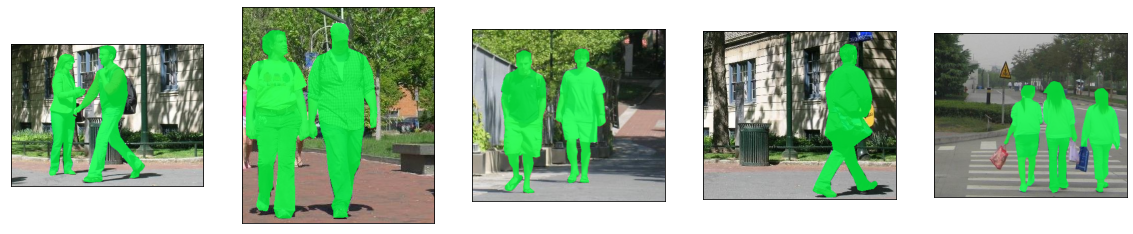

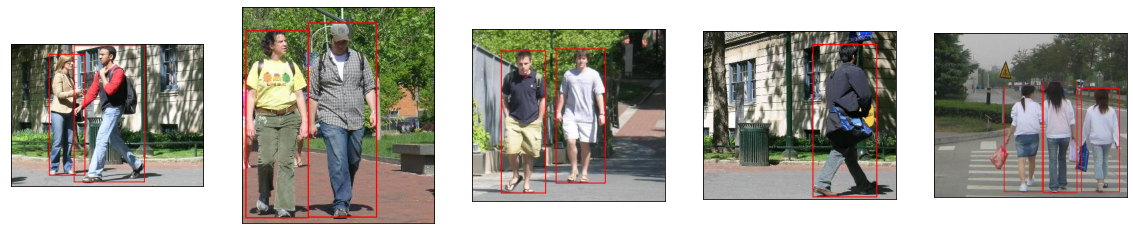

In [ ]:
transform_to_tensor = transforms.Compose([
    transforms.ToTensor()])

transform_to_pil_img = transforms.Compose([
    transforms.ToPILImage()])

img_names, mask_names = get_imgs_and_masks('PennFudanPed/', False)
drawn_masks = []
drawn_boxes = []

for i in range(5):
  img = Image.open(img_names[i]).convert('RGB')
  mask = Image.open(mask_names[i])
  boxes, _ = extract_boxes(mask)
  img = transform_to_tensor(img) * 255
  img = torch.tensor(img, dtype=torch.uint8)

  # https://pytorch.org/vision/stable/utils.html
  drawn_boxes.append(torchvision.utils.draw_bounding_boxes(img, boxes, colors=["red"]*len(boxes), width=2))

  mask = transform_to_tensor(mask.convert('RGB'))
  mask = torch.tensor(mask, dtype=torch.bool)

  # https://pytorch.org/vision/stable/utils.html
  drawn_masks.append(torchvision.utils.draw_segmentation_masks(img, mask))

drawn_masks = [transform_to_pil_img(img) for img in drawn_masks]
drawn_boxes = [transform_to_pil_img(img) for img in drawn_boxes]

show_imgs(drawn_masks)
show_imgs(drawn_boxes)

### **Задание 2** (2 балла)

Посмотрите, в каком виде данные нужны будут детектору и лоссу для работы. Напишите `Dataset`, заведите по нему loader-ы для трейна и теста, проверьте что всё ок.

In [ ]:
class PedestrianSet(torch.utils.data.Dataset):
    def __init__(self, root, transforms, is_train=True, class_label=1):
        self.root = root
        self.transforms = transforms
        self.is_train = is_train
        self.class_label = class_label    # в данном случае у нас один класс 15 (person), удобно завести это поле, чтобы менять номер лейбла

        imgs, masks = get_imgs_and_masks(self.root, self.is_train)
        self.imgs = imgs
        self.masks = masks

    def __getitem__(self, idx):

        img = Image.open(self.imgs[idx])
        mask = Image.open(self.masks[idx])

        boxes, num_objs = extract_boxes(mask)
        original_dims = torch.FloatTensor([img.width, img.height, img.width, img.height]).unsqueeze(0)
        boxes = boxes / original_dims

        if self.transforms is not None:
          img = self.transforms(img)

        x = np.repeat(self.class_label, (num_objs,))
        labels = torch.tensor(x, dtype=torch.int64)
        
        return img, boxes, labels

    def __len__(self):
        return len(self.imgs)

In [ ]:
transform = transforms.Compose([
                transforms.Resize((300, 300)),
                transforms.ToTensor()])

# для отрисовки
transform_to_pil_img = transforms.Compose([
    transforms.ToPILImage()])

In [ ]:
trainset = PedestrianSet(root='PennFudanPed/', transforms=transform, is_train=True, class_label=15)
testset = PedestrianSet(root='PennFudanPed/', transforms=transform, is_train=False, class_label=15)

In [ ]:
def collate(batch):
    imgs = []
    boxes = []
    labels = []
    for item in batch:
        img, box, label = item
        imgs.append(img)
        boxes.append(box)
        labels.append(label)

    imgs = torch.stack(imgs, dim=0)
    return imgs, boxes, labels

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, num_workers=8, shuffle=True, pin_memory=True, collate_fn=collate)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, num_workers=8, shuffle=False, pin_memory=True, collate_fn=collate)

In [ ]:
# посмотрим на то, что получилось в dataset

pics = []
for batch_imgs, batch_boxes, batch_labels in testloader:
    for i, img in enumerate(batch_imgs):
      name_labels = [rev_label_map[l.item()] for l in batch_labels[i]]
      original_dims = torch.FloatTensor([300, 300, 300, 300]).unsqueeze(0)
      batch_boxes[i] = batch_boxes[i] * original_dims
      pic = draw_boxes(transform_to_pil_img(img), batch_boxes[i], name_labels, label_color_map)
      pics.append(pic)

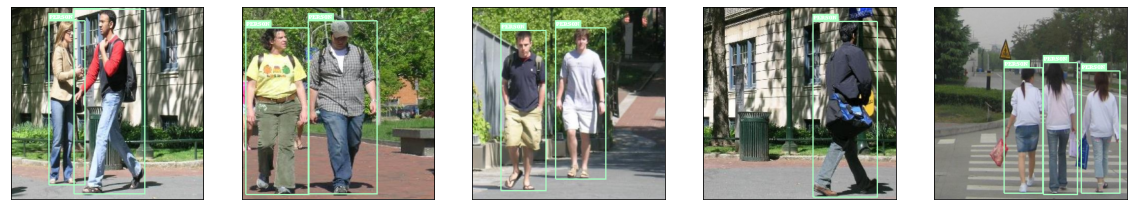

In [ ]:
show_imgs(pics[:5])

## **Часть 2. Копаемся в SSD**

Глобальная идея - мы хотим проверить следующую гипотезу: если взять предобученный детектор, оставить ему одну голову только на один класс и затюнить его на моноклассовый датасет, то на тесте этого датасета мы получим лучше результат, чем на нем давал этот детектор первоначально. 

### **Задание 3**. (4 балла) 

Тогда сперва давайте получим результат детекции для класса `person` у первоначальной сети (никак не измененной) на `pedestrian test` сете. 

Что для этого нужно: 
 - получить предсказания детектора на всех фотках теста (1 балл)
 - написать функцию для подсчета `AP` (2 балла)
 - посчитать `АР` для класса `person` при `IoU=0.75` с gt (1 балл)

Ещё раз почитать про AP [тут](https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173) или на русском то же самое [тут](https://ml.i-neti.com/2019/07/05/russkiy-map-mean-average-precision-v-detektsii-obektov/).

Сразу скажу, что можно использовать код из [pycocotools](https://github.com/cocodataset/cocoapi/tree/master/PythonAPI/pycocotools), но не втупую. Возьмите оттуда только нужные для нашей задачи части. Во многих репозиториях вы увидите, что процедуры написаны специально для [coco](https://cocodataset.org/#home) - просто потому что это самый популярный датасет для детектирования и сегментации.

In [ ]:
# предсказание на предобученной модели

def get_prediction(testloader, model):
  det_boxes_all = []
  det_labels_all = []
  det_scores_all = []
  true_boxes_all = []
  true_labels_all = []
  imgs_all = []

  for batch_imgs, batch_boxes, batch_labels in testloader:
      batch_imgs = batch_imgs.to(device)
      batch_boxes = [batch_boxes[k].to(device) for k in range(len(batch_boxes))]

      locs, scores = model(batch_imgs)
      det_boxes, det_labels, det_scores = model.detect_objects(locs.detach(), scores.detach(), min_score=0.5, max_overlap=0.5, top_k=10)
      original_dims = torch.FloatTensor([300, 300, 300, 300]).unsqueeze(0).to(device)

      det_labels_names = []
      true_labels_names = []

      for k in range(len(det_labels)):
        det_labels_names.append([rev_label_map[l] for l in det_labels[k].to('cpu').tolist()])
        true_labels_names.append([rev_label_map[l] for l in batch_labels[k].to('cpu').tolist()])

      for k, _ in enumerate(det_boxes):
        det_boxes[k] = det_boxes[k] * original_dims
        batch_boxes[k] = batch_boxes[k] * original_dims
        
      det_boxes_all.append(det_boxes)
      det_labels_all.append(det_labels_names)
      det_scores_all.append(det_scores)
      true_boxes_all.append(batch_boxes)
      true_labels_all.append(true_labels_names)
      imgs_all.append(batch_imgs)

  return det_boxes_all, det_labels_all, det_scores_all, true_boxes_all, true_labels_all, imgs_all

In [ ]:
def calculate_AP(det_boxes, det_labels, det_scores, true_boxes, true_labels, class_label, iou_threshold, plot=False):

  # отсортируем по скорам
  scores = []
  scores_dict = {}
  for i in range(len(det_scores)):
    if class_label in det_labels[i]:
      scores.append(det_scores[i])
      for j in range(det_scores[i].shape[0]):
        scores_dict[i, j] = det_scores[i][j].item()

  scores_list = torch.cat(scores).cpu()

  sort_scores = np.sort(scores_list)[::-1]

  scores_dict_reversed = dict(zip(scores_dict.values(), scores_dict.keys()))
  
  sort_inds = []
  for el in sort_scores:
    ind = scores_dict_reversed[el]
    sort_inds.append(ind)

  # общее кол-во gr
  n = 0
  match_boxes = []
  for i in range(len(true_boxes)):
    if class_label in true_labels[i]:
      n += len(true_boxes[i])
      match_boxes.append(np.zeros(len(true_labels[i])))

  precision = []
  recall = []
  rec = 0
  num = 1
  correct = 0

  img_det_counter = np.zeros(len(det_scores))

  for ind in sort_inds:

    img_ind, img_obj_ind = ind

    img_det_counter[img_ind] += 1
    
    ious = []
    for i in range(len(true_boxes[img_ind])):
      iou = find_jaccard_overlap(true_boxes[img_ind][i][None, :].to(device), det_boxes[img_ind][img_obj_ind][None, :]).cpu()
      ious.append(iou)

    sort_inds = np.argsort(ious)[::-1]

    fl = True
    for i in sort_inds:

      if fl:
        if match_boxes[img_ind][i] == 0:
          if ious[i] > iou_threshold:
            correct += 1
            match_boxes[img_ind][i] = 1
            rec += 1 / n
            fl = False

          if not fl or img_det_counter[img_ind] == det_scores[img_ind].shape[0]:
            # рассчитываем precision, recall
            pr = correct / num
            num += 1
            precision.append(pr)
            recall.append(rec)

  # интерполируем полученный precision, чтобы получить строго монотонную функцию
  for i in range(1, len(precision)-1)[::-1]:
    if precision[i] != 1:
      if precision[i+1] - precision[i] > 0:
        precision[i] = precision[i+1]

  # изобразим полученную кривую
  if plot:
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

  return np.trapz(precision, x=recall)

In [ ]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [ ]:
det_boxes_all, det_labels_all, det_scores_all, true_boxes_all, true_labels_all, imgs_all = get_prediction(testloader, ssd)

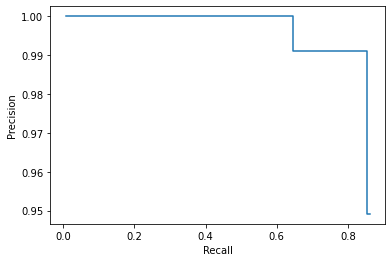

Average precision for class "Person":  0.8516006239523167


In [ ]:
# посмотрим на точность при пороге 0.5

ap = calculate_AP(flatten(det_boxes_all), flatten(det_labels_all), flatten(det_scores_all), 
                  flatten(true_boxes_all), flatten(true_labels_all), 'person', 0.5, True)

print('Average precision for class "Person": ', ap)

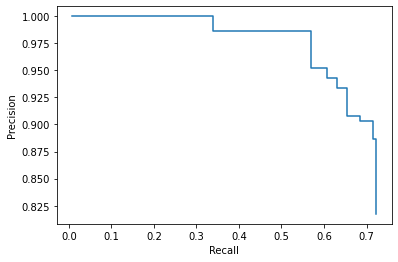

Average precision for class "Person":  0.7009224319474157


In [ ]:
# посмотрим на точность при пороге 0.75

ap = calculate_AP(flatten(det_boxes_all), flatten(det_labels_all), flatten(det_scores_all), 
                  flatten(true_boxes_all), flatten(true_labels_all), 'person', 0.75, True)

print('Average precision for class "Person": ', ap)

In [ ]:
pics = []
k = 0
for batch_imgs, batch_boxes, batch_labels in testloader:
    for i in range(1):
      name_labels = [rev_label_map[l.item()] for l in batch_labels[i]]
      pic = draw_boxes(transform_to_pil_img(batch_imgs[i]), det_boxes_all[k][i], det_labels_all[k][i], label_color_map)
      pics.append(pic)
    k += 1

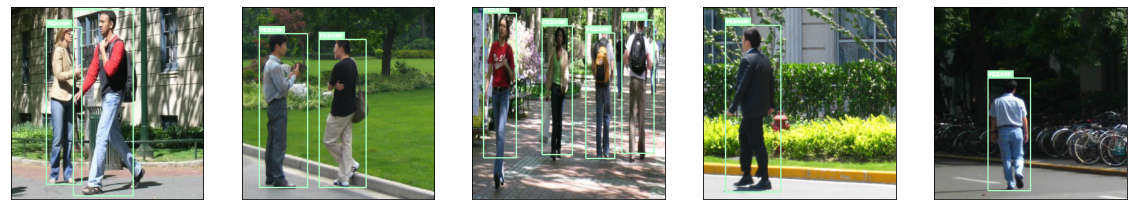

In [ ]:
# посмотрим на предсказанные боксы

show_imgs(pics[:5])

### **Задание 4**. (12 баллов) 

А вот теперь будем играться с моноклассовой модификацией детектора.

1. Замените головы нашего `SSD300` так, чтобы теперь он детектировал только один класс. Вы можете создать новый экземпляр класса с другим параметром и аккуратно подтащить веса, либо уже у существующего `pretrained` детектора заменить необходимые слои (2 балла) 

2. Подготовьте код для обучения и тестирования. **Явно пропишите свои функции train_epoch** (3 балла), **evaluate** (2 балла).

Процедуры обучения и эвала можно посмотреть тут: [тык 1](https://github.com/pytorch/vision/blob/master/references/detection/engine.py), [тык 2](https://github.com/multimodallearning/pytorch-mask-rcnn/blob/master/model.py#L1736), [тык 3](https://github.com/pytorch/vision/blob/0467c9d74c9b34f91df905ed8cf8433de48d7fa5/references/detection/coco_eval.py#L19). А ещё можно покопаться в одной из самых известных (но чуть более сложной чем у нас) реализаций [ssd на pytorch](https://github.com/amdegroot/ssd.pytorch). 

3. Поэкспериментируйте и постарайтесь выйти на хорошее качество на test - **bbox AP@IoU=0.75 >=0.95**. Попробуйте разные аугментации, lr, оптимайзеры, заморозку слоев и что ещё хочется (может быть самые смелые даже набор якорей попробуют поменять?). Напишите резюме - что получилсь, что нет, что зашло - а что не оч. (5 баллов)

Какой результат проверки гипотезы? Лучше ли тюнить детектор или и так было норм?

In [ ]:
ssd2 = SSD300(2)


 Loaded backbone.



In [ ]:
# возьмем все веса, кроме pred_convs

new_weights = {}
for key in ssd2.state_dict():
  if "pred_convs" not in key:
    new_weights[key] = checkpoint['state_dict'][key]
  else:
    new_weights[key] = ssd2.state_dict()[key]

In [ ]:
ssd2.load_state_dict(new_weights)

<All keys matched successfully>

In [ ]:
# заморозим веса

# for name, param in ssd.named_parameters():
#   if ("pred_convs" not in name) and (param.requires_grad):
#     param.requires_grad = False

In [ ]:
# переопределим label_map под новое число классов (background и person)

label_map = {"background": 0, "person": 1}
rev_label_map = {v: k for k, v in label_map.items()}

# https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
distinct_colors = ['#e6194b', '#3cb44b']
label_color_map = {k: distinct_colors[i] for i, k in enumerate(label_map.keys())}

In [ ]:
trainset = PedestrianSet(root='PennFudanPed/', transforms=transform, is_train=True, class_label=1)
testset = PedestrianSet(root='PennFudanPed/', transforms=transform, is_train=False, class_label=1)

batch_size = 10
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, num_workers=8, shuffle=True, pin_memory=True, collate_fn=collate)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, num_workers=8, shuffle=False, pin_memory=True, collate_fn=collate)

In [ ]:
n_epochs = 20

optimizer = torch.optim.SGD(ssd2.parameters(), lr=1e-3, momentum=0.9)
# optimizer = torch.optim.Adam(ssd2.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(len(trainset)/batch_size + 1)*n_epochs)
criterion = MultiBoxLoss(ssd2.priors_cxcy)

In [ ]:
class EmptyContext:
    def __enter__(self):
        pass
    
    def __exit__(self, *args):
        pass

In [ ]:
# объединим train и eval в одну функцию (как в первой лекции), optimizer == None: eval

def perform_epoch(net, dataloader, criterion, optimizer=None, device=None):

    if device is not None:
      net = net.to(device)

    if optimizer is None:
      net.eval()
    else:
      net.train()

    total_loss = 0

    det_boxes_all = []
    det_labels_all = []
    det_scores_all = []
    true_boxes_all = []
    true_labels_all = []
    imgs_all = []

    with EmptyContext() if optimizer is not None else torch.no_grad():
      for i, (batch_imgs, batch_boxes, batch_labels) in enumerate(dataloader):
        
        batch_imgs = batch_imgs.to(device)
        batch_boxes = [b.to(device)  for b in batch_boxes]
        batch_labels = [l.to(device) for l in batch_labels]

        locs, scores = net(batch_imgs)
        loss = criterion(locs, scores, batch_boxes, batch_labels)

        # backprop
        if optimizer is not None:
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          scheduler.step()

        total_loss += loss.item()

        det_boxes, det_labels, det_scores = net.detect_objects(locs.detach(), scores.detach(), min_score=0.5, max_overlap=0.5, top_k=10)
        original_dims = torch.FloatTensor([300, 300, 300, 300]).unsqueeze(0).to(device)

        det_labels_names = []
        for k in range(len(det_labels)):
          det_labels_names.append([rev_label_map[l.item()] for l in det_labels[k]])

        for k in range(len(det_boxes)):
          det_boxes[k] = det_boxes[k] * original_dims
          batch_boxes[k] = batch_boxes[k] * original_dims

        true_labels_names = []
        for k in range(len(batch_imgs)):
          true_labels_names.append([rev_label_map[l.item()] for l in batch_labels[k]])

        det_boxes_all.append(det_boxes)
        det_labels_all.append(det_labels_names)
        det_scores_all.append(det_scores)
        true_boxes_all.append(batch_boxes)
        true_labels_all.append(true_labels_names)
        imgs_all.append(batch_imgs)

    
    ap = calculate_AP(flatten(det_boxes_all), flatten(det_labels_all), flatten(det_scores_all), 
                  flatten(true_boxes_all), flatten(true_labels_all), 'person', 0.75, False)
    
    return total_loss, ap

In [ ]:
ssd2 = ssd2.to(device)

train_loss = []
test_loss = []
train_aps = []
test_aps = []

for epoch in range(n_epochs):
    loss_train, ap_train = perform_epoch(ssd2, trainloader, criterion, optimizer=optimizer, device=device)
    loss_test, ap_test = perform_epoch(ssd2, testloader, criterion, optimizer=None, device=device)
    train_loss.append(loss_train)
    test_loss.append(loss_test)
    train_aps.append(ap_train)
    test_aps.append(ap_test)

    print(f"Epoch: [{epoch+1} / {n_epochs}], Train loss: {round(loss_train,4)}, Train AP: {round(ap_train,4)}")
    print(f"Epoch: [{epoch+1} / {n_epochs}], Test loss: {round(loss_test,4)}, Test AP: {round(ap_test,4)}")
    print('-------')

Epoch: [1 / 20], Train loss: 52.4656, Train AP: 0.0145
Epoch: [1 / 20], Test loss: 21.4793, Test AP: 0.1579
-------
Epoch: [2 / 20], Train loss: 40.9754, Train AP: 0.0607
Epoch: [2 / 20], Test loss: 17.8531, Test AP: 0.1741
-------
Epoch: [3 / 20], Train loss: 34.2556, Train AP: 0.1152
Epoch: [3 / 20], Test loss: 14.8224, Test AP: 0.4069
-------
Epoch: [4 / 20], Train loss: 28.7354, Train AP: 0.241
Epoch: [4 / 20], Test loss: 12.7084, Test AP: 0.4612
-------
Epoch: [5 / 20], Train loss: 25.1802, Train AP: 0.4116
Epoch: [5 / 20], Test loss: 12.0898, Test AP: 0.53
-------
Epoch: [6 / 20], Train loss: 22.7869, Train AP: 0.5133
Epoch: [6 / 20], Test loss: 11.4731, Test AP: 0.5728
-------
Epoch: [7 / 20], Train loss: 19.8368, Train AP: 0.5315
Epoch: [7 / 20], Test loss: 11.4727, Test AP: 0.5638
-------
Epoch: [8 / 20], Train loss: 18.0744, Train AP: 0.5842
Epoch: [8 / 20], Test loss: 11.4846, Test AP: 0.6092
-------
Epoch: [9 / 20], Train loss: 16.9982, Train AP: 0.5988
Epoch: [9 / 20], Tes

In [ ]:
# сделаем предсказания на тесте
det_boxes_all, det_labels_all, det_scores_all, true_boxes_all, true_labels_all, imgs_all = get_prediction(testloader, ssd2)

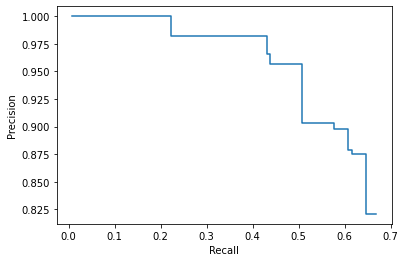

Average precision for class "Person":  0.6358918259847536


In [ ]:
# ap, порог = 0.75

ap = calculate_AP(flatten(det_boxes_all), flatten(det_labels_all), flatten(det_scores_all), 
                  flatten(true_boxes_all), flatten(true_labels_all), 'person', 0.75, True)
print('Average precision for class "Person": ', ap)

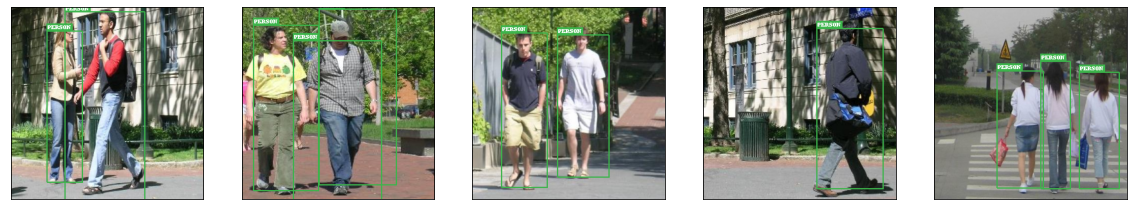

In [ ]:
# посмотрим на детекции

pics = []
k = 0
for batch_imgs, batch_boxes, batch_labels in testloader:
    for i in range(len(batch_imgs)):
      name_labels = [rev_label_map[l.item()] for l in batch_labels[i]]
      pic = draw_boxes(transform_to_pil_img(batch_imgs[i]), det_boxes_all[k][i], det_labels_all[k][i], label_color_map)
      pics.append(pic)
    k += 1

show_imgs(pics[:5])

Кажется, что все не очень неплохо

**Резюме:**

- Было ооочень непросто, но крайне интересно:)

- Очень важно выбрать подходящий оптимизатор (Adam вообще не заходил)

- Sheduler помогает

- Заморозка весов не привела к значительному изменению метрик

- Аугментацию уже не успела попробовать:(